In [ ]:
# Part 1: Build Co-occurrence Matrix
import numpy as np
from collections import defaultdict
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

In [ ]:
# Define a larger corpus
corpus = [
    "Natural language processing enables computers to understand human language.",
    "Machine learning is a part of artificial intelligence.",
    "Deep learning is a subfield of machine learning.",
    "Text data can be used for sentiment analysis.",
    "Named entity recognition is an information extraction technique.",
    "GloVe stands for Global Vectors for Word Representation.",
    "It captures semantic relationships between words.",
    "Word embeddings are useful for NLP applications.",
    "This tutorial implements GloVe from scratch.",
    "Sentiment analysis determines if a sentence is positive or negative."
]

In [ ]:
# Clean and tokenize
def preprocess(sentence):
    return re.sub(r"[^a-zA-Z ]", "", sentence).lower().split()

tokenized = [preprocess(sentence) for sentence in corpus]

In [ ]:
# Build vocabulary
vocab = sorted(set(itertools.chain(*tokenized)))
vocab_size = len(vocab)
word2id = {word: i for i, word in enumerate(vocab)}
id2word = {i: word for word, i in word2id.items()}

print("Vocabulary size:", vocab_size)

Vocabulary size: 61


In [ ]:
# Build Co-occurrence Matrix
def build_cooccurrence_matrix(tokenized_corpus, vocab_size, word2id, window_size=2):
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float64)

    for sentence in tokenized_corpus:
        sentence_ids = [word2id[word] for word in sentence]
        for idx, word_id in enumerate(sentence_ids):
            start = max(idx - window_size, 0)
            end = min(idx + window_size + 1, len(sentence_ids))
            for context_idx in range(start, end):
                if context_idx != idx:
                    context_id = sentence_ids[context_idx]
                    cooccurrence_matrix[word_id, context_id] += 1
    return cooccurrence_matrix

X = build_cooccurrence_matrix(tokenized, vocab_size, word2id, window_size=2)
print("Co-occurrence Matrix shape:", X.shape)

Co-occurrence Matrix shape: (61, 61)


In [ ]:
# Part 2: Initialize GloVe Parameters
np.random.seed(42)
embedding_dim = 50

W = np.random.randn(vocab_size, embedding_dim) / np.sqrt(embedding_dim)
W_tilde = np.random.randn(vocab_size, embedding_dim) / np.sqrt(embedding_dim)
biases_w = np.zeros(vocab_size)
biases_tilde = np.zeros(vocab_size)

non_zero_indices = np.nonzero(X)

# Weighting function
def weighting_func(x, x_max=100, alpha=0.75):
    f_x = np.where(x < x_max, (x / x_max) ** alpha, 1.0)
    return f_x

weights = weighting_func(X)

In [ ]:
# Part 3: Train GloVe Embeddings
learning_rate = 0.05
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for i, j in zip(*non_zero_indices):
        x_ij = X[i, j]
        w_i = W[i]
        w_j = W_tilde[j]
        b_i = biases_w[i]
        b_j = biases_tilde[j]

        weight = weights[i, j]
        inner_product = np.dot(w_i, w_j)
        log_x_ij = np.log(x_ij)

        diff = (inner_product + b_i + b_j - log_x_ij)
        loss = weight * (diff ** 2)
        total_loss += loss

        grad_w_i = weight * diff * w_j
        grad_w_j = weight * diff * w_i
        grad_b_i = weight * diff
        grad_b_j = weight * diff

        W[i] -= learning_rate * grad_w_i
        W_tilde[j] -= learning_rate * grad_w_j
        biases_w[i] -= learning_rate * grad_b_i
        biases_tilde[j] -= learning_rate * grad_b_j

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 10/100, Loss: 0.1256
Epoch 20/100, Loss: 0.1139
Epoch 30/100, Loss: 0.1036
Epoch 40/100, Loss: 0.0944
Epoch 50/100, Loss: 0.0862
Epoch 60/100, Loss: 0.0788
Epoch 70/100, Loss: 0.0722
Epoch 80/100, Loss: 0.0662
Epoch 90/100, Loss: 0.0608
Epoch 100/100, Loss: 0.0559


In [ ]:
# Final embeddings
embeddings = W + W_tilde

In [ ]:
# Part 4: Word Similarity (demo)
def most_similar(word, embeddings, word2id, id2word, top_n=5):
    idx = word2id[word]
    vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(vec, embeddings)[0]
    top_ids = sims.argsort()[::-1][1:top_n+1]
    return [(id2word[i], sims[i]) for i in top_ids]

print("\nSimilar words to 'learning':", most_similar("sentiment", embeddings, word2id, id2word))


Similar words to 'learning': [('embeddings', np.float64(0.40615403525364774)), ('implements', np.float64(0.39622953090472374)), ('analysis', np.float64(0.3076650026745394)), ('relationships', np.float64(0.17967339996172213)), ('are', np.float64(0.14509641340189725))]


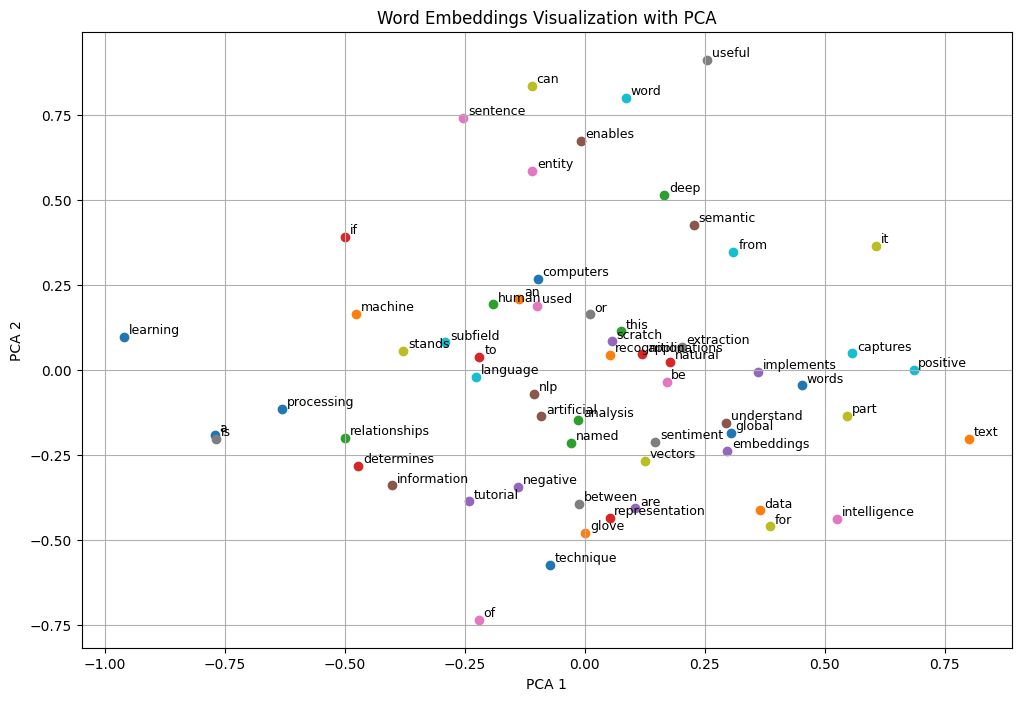

In [ ]:
# Part 5: Visualize Embeddings
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
for i, word in id2word.items():
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9)

plt.title("Word Embeddings Visualization with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [ ]:
# Part 6: NLP Task - Sentiment Classification
# Define a toy dataset for sentiment analysis
sentences = [
    "I love natural language processing",
    "Deep learning is amazing",
    "This is a great tutorial",
    "I hate bugs in the code",
    "Debugging is so frustrating",
    "Errors make me angry"
]
labels = [1, 1, 1, 0, 0, 0]  # 1 = positive, 0 = negative

# Preprocess and average word vectors
X_data = []
for sent in sentences:
    words = preprocess(sent)
    vectors = [embeddings[word2id[word]] for word in words if word in word2id]
    if vectors:
        avg_vec = np.mean(vectors, axis=0)
    else:
        avg_vec = np.zeros(embedding_dim)
    X_data.append(avg_vec)

# Train a classifier
clf = LogisticRegression()
clf.fit(X_data, labels)

# Evaluate on training data
preds = clf.predict(X_data)
acc = accuracy_score(labels, preds)
print("\nSentiment Classification Accuracy:", acc)
for sent, label, pred in zip(sentences, labels, preds):
    print(f"{sent} => Actual: {label}, Predicted: {pred}")


Sentiment Classification Accuracy: 1.0
I love natural language processing => Actual: 1, Predicted: 1
Deep learning is amazing => Actual: 1, Predicted: 1
This is a great tutorial => Actual: 1, Predicted: 1
I hate bugs in the code => Actual: 0, Predicted: 0
Debugging is so frustrating => Actual: 0, Predicted: 0
Errors make me angry => Actual: 0, Predicted: 0
